In [1]:
import argparse as ap
from tqdm import tqdm
import pickle
import time
import os

from scipy.cluster.vq import vq, kmeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

In [2]:
def data_parse(data_path, interval=5):
    image_paths = []
    training_names = os.listdir(data_path)
    training_names.sort()
    training_names = training_names[::interval] # 原始数据太多,15 FPS 没必要区很多重复的东西
    for training_name in training_names:
        image_path = os.path.join(data_path, training_name)
        image_paths += [image_path]
    return image_paths, training_names

data_path = "/media/ubuntu/zoro/ubuntu/data/rail/data"
data_forward = data_path + "/forward/00/image_0/"
data_side    = data_path + "/side/00/image_0/"
numWords = 1000

forward_paths, forword_names = data_parse(data_forward)
side_paths, side_names = data_parse(data_side)

# The number of images for the front and side does not need to be the same. Set to the same here.
n = min(len(forward_paths), len(side_paths))
forward_paths = forward_paths[:n]
side_paths = side_paths[:n]
print(len(side_paths) == len(forward_paths))

True


### 1, 提取存储orb特征

In [3]:
# 循环结构 可以加速, 函数也可以加速好像
def extractORB(data_paths):
    des_list = [] 
    orb = cv2.ORB_create()
    for image_path in tqdm(data_paths, desc='Processing'):
    # for i, image_path in enumerate(tqdm(data_paths)):
        im = cv2.imread(image_path)
        kpts, des  = orb.detectAndCompute(im, None)
        des = des.astype('float32')
        des_list.append((image_path, des))
    descriptors = des_list[0][1]
    
    print("Stack all the descriptors vertically in a numpy array ... ")
    for image_path, descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
    return descriptors, des_list

In [4]:
descriptorsF, desF_list = extractORB(forward_paths)
descriptorsS, desS_list = extractORB(side_paths)

100%|██████████| 2337/2337 [00:22<00:00, 101.66it/s]


### 2, 聚类学习 “视觉词典（visual vocabulary）

In [5]:
def generateVoc(image_paths, descriptors, des_list, numWords, saveVoc_path):
    n = len(image_paths)
    voc, variance = kmeans(descriptors, numWords, 1) # 质心, 平均距离

    # Calculate the histogram of features
    im_features = np.zeros((n, numWords), "float32")
    for i in range(n):
        words, distance = vq(des_list[i][1],voc)
        for w in words:
            im_features[i][w] += 1

    # Perform Tf-Idf vectorization
    nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
    idf = np.array(np.log((1.0*n + 1) / (1.0*nbr_occurences + 1)), 'float32')

    # Perform L2 normalization
    im_features = im_features * idf
    im_features = preprocessing.normalize(im_features, norm='l2')

    with open(saveVoc_path,'wb') as f:
        pickle.dump((im_features, image_paths, idf, numWords, voc), f)

In [6]:
saveVocF_path="../vocabulary/vocF_orb.pkl"
saveVocS_path="../vocabulary/vocS_orb.pkl"
generateVoc(forward_paths, descriptorsF, desF_list, numWords, saveVocF_path)
generateVoc(side_paths, descriptorsS, desS_list, numWords, saveVocS_path)

### 3, Fusion Query 
Train 2 vocabularies, and then fuse the prediction results

In [16]:
def query_SingleImage(src_image, im, im_features, voc, idf):
    orb = cv2.ORB_create()
    des_list = []
    kpts, des  = orb.detectAndCompute(im, None)
    des = des.astype('float32')
    des_list.append((src_image, des))

    # Stack all the descriptors vertically in a numpy array
    descriptors = des_list[0][1]
    test_features = np.zeros((1, numWords), "float32")
    words, distance = vq(descriptors,voc)
    for w in words:
        test_features[0][w] += 1

    # Perform Tf-Idf vectorization and L2 normalization
    test_features = test_features * idf
    test_features = preprocessing.normalize(test_features, norm='l2')
    
    # Query
    # for test top x result 
    # score = np.dot(test_features, im_features.T)
    # rank_ID = np.argsort(-score) 

    score = np.dot(test_features, im_features.T)[0]
    rank_ID = np.argsort(-score) 
    idx = rank_ID[0]

    return score[idx], idx

In [24]:
data = "/media/ubuntu/zoro/ubuntu/data/rail/data"
# src_image = data + "/forward/00/image_0/000018.png"
src_image = data + "/side/00/image_0/000018.png"

pklF_path = "../vocabulary/vocF_orb.pkl"
pklS_path = "../vocabulary/vocS_orb.pkl"

In [31]:
start_time = time.time()

imF_features, dstF_image, idfF, numWordsF, vocF = pickle.load(open(pklF_path,'rb'))
imS_features, dstS_image, idfS, numWordsS, vocS = pickle.load(open(pklS_path,'rb'))

im = cv2.imread(src_image)
score1, idx1 = query_SingleImage(src_image, im, imF_features, vocF, idfF)
score2, idx2 = query_SingleImage(src_image, im, imS_features, vocS, idfS)

# result fusion
if score1>0.25 or score2> 0.25:
    if score1 > score2:
        score = score1
        idx = idx1
        dst_image = dstF_image
    else:
        score = score2
        idx = idx2
        dst_image = dstS_image
else:
    print("No matching results ... ")

end_time = time.time()
print("score1:{:.3f}, class_index: {:d}".format(score1, idx1))
print("score2:{:.3f}, class_index: {:d}".format(score2, idx2))
print("run time: {:.2f}s, FPS:{:.1f}".format(end_time-start_time, 1.0 / (end_time-start_time)))

score1:0.388, class_index: 1081
score2:0.625, class_index: 4
run time: 0.02s, FPS:40.4


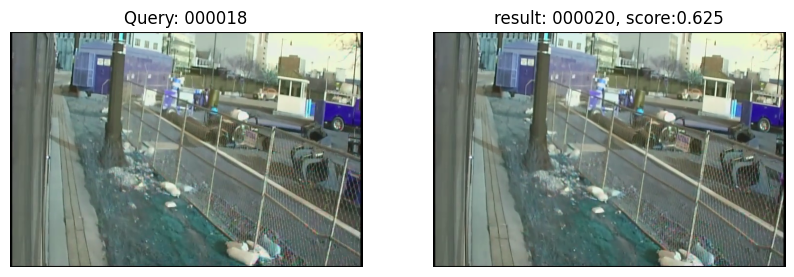

In [32]:
out = cv2.imread(dst_image[idx])

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(im)
plt.title("Query: "+ src_image[-10:-4]) 
plt.axis('off')

plt.subplot(122)
plt.title("result: "+ dst_image[idx2][-10:-4] + ', score:'+str(round(score,3)))
plt.axis('off')
plt.imshow(out)
plt.show()